# **Imports**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch 
import torchvision
import torch.nn as nn
import torch.optim as optim 
from torchvision import models, datasets, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader


import cv2
import glob
import os
import random
import copy
from pandas.core.common import flatten  


# **Data Augmentation** 

In [2]:
train_transforms = A.Compose(
    [   
        A.Resize(224, 224),
        A.RandomBrightnessContrast(p=0.2), 
        A.CenterCrop(height=200, width=200),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_transforms = A.Compose(
    [
        A.Resize(224, 224),
        A.RandomBrightnessContrast(p=0.2),
        A.CenterCrop(height=200, width=200),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)

test_transforms = A.Compose(
    [   
        A.Resize(224, 224),
        A.CenterCrop(height=200, width=200),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)

# **Path**

In [3]:
train_data_path = '../input/animal-image-dataset-90-different-animals/animals/animals'


# **Data Preparation**

In [4]:

image_paths = [] #to store image paths in list
classes = [] #to store class values


for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    image_paths.append(glob.glob(data_path + '/*'))
    
image_paths = list(flatten(image_paths))
random.shuffle(image_paths)

print('image_path example: ', image_paths[8])
print('class example: ', classes[8])

#2.
# split train valid from train paths (80,20)
train_image_paths, valid_image_paths, test_image_paths = image_paths[:int(0.6*len(image_paths))], image_paths[int(0.6*len(image_paths)):int(0.8*len(image_paths))],image_paths[int(0.8*len(image_paths)):]


print(f"\nTrain size: {len(train_image_paths)}\nValid size: {len(valid_image_paths)}\nTest Size : {len(test_image_paths)}")

image_path example:  ../input/animal-image-dataset-90-different-animals/animals/animals/jellyfish/8a4e2674dc.jpg
class example:  horse

Train size: 3240
Valid size: 1080
Test Size : 1080


# **Label Encoding**

In [5]:
# let's generate label of each class
idx_to_cls = {i:j for i, j in enumerate(classes)}
# print(idx_to_cls)
cls_to_idx = {value:key for key, value in idx_to_cls.items()}
cls_to_idx

{'beetle': 0,
 'parrot': 1,
 'fox': 2,
 'wolf': 3,
 'hedgehog': 4,
 'turtle': 5,
 'snake': 6,
 'shark': 7,
 'horse': 8,
 'antelope': 9,
 'hamster': 10,
 'woodpecker': 11,
 'eagle': 12,
 'chimpanzee': 13,
 'bison': 14,
 'penguin': 15,
 'butterfly': 16,
 'sandpiper': 17,
 'hornbill': 18,
 'lion': 19,
 'lobster': 20,
 'oyster': 21,
 'otter': 22,
 'grasshopper': 23,
 'raccoon': 24,
 'dog': 25,
 'pigeon': 26,
 'donkey': 27,
 'hippopotamus': 28,
 'hummingbird': 29,
 'bear': 30,
 'coyote': 31,
 'bee': 32,
 'pig': 33,
 'rat': 34,
 'owl': 35,
 'caterpillar': 36,
 'koala': 37,
 'squid': 38,
 'hare': 39,
 'whale': 40,
 'mouse': 41,
 'tiger': 42,
 'fly': 43,
 'lizard': 44,
 'orangutan': 45,
 'bat': 46,
 'porcupine': 47,
 'kangaroo': 48,
 'gorilla': 49,
 'starfish': 50,
 'mosquito': 51,
 'crow': 52,
 'possum': 53,
 'goldfish': 54,
 'swan': 55,
 'elephant': 56,
 'sheep': 57,
 'dragonfly': 58,
 'zebra': 59,
 'seal': 60,
 'octopus': 61,
 'cow': 62,
 'ox': 63,
 'wombat': 64,
 'reindeer': 65,
 'panda': 

# **Spliting Data, with its Labels**

In [6]:
class FolderTypeDataSets(Dataset):
    def __init__(self, image_paths, transform=True):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = cls_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label


train_dataset = FolderTypeDataSets(train_image_paths,train_transforms)
valid_dataset = FolderTypeDataSets(valid_image_paths,val_transforms) #test transforms are applied
test_dataset = FolderTypeDataSets(test_image_paths,test_transforms)

# **Data Loader**

In [7]:

dataloaders = {
    'train':
    DataLoader(train_dataset,
                batch_size=32,
                shuffle=True,
                num_workers=0),  # for Kaggle
    'validation':
    DataLoader(valid_dataset,
                batch_size=32,
                shuffle=True,
                num_workers=0),  # for Kaggle,
    'test':
    DataLoader(test_dataset,
                batch_size=32,
                shuffle=True,
                num_workers=0    
    )                                
}



# **Visualization Of Dataset**

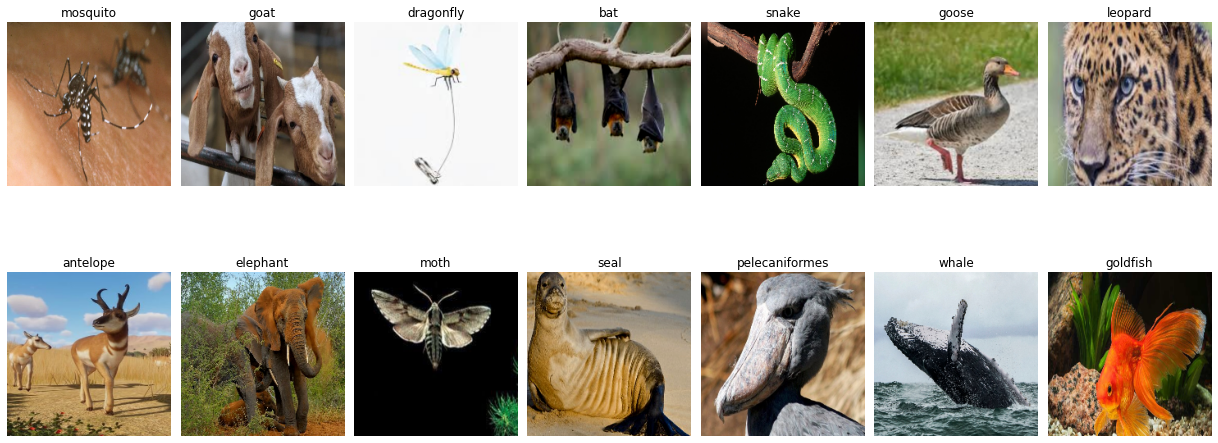

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline



def visualize_augmentations(dataset, idx=0, samples=14, cols=7, random_img = False):
    
    dataset = copy.deepcopy(dataset)

    # it is asking, if there is transform in that dataset, then take it as "t"
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))]) 
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(17, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(dataset))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_cls[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset, random_img = True)


# **Transfer Learning with VGG16**

In [9]:
# from torchvision.models import VGG16_Weights
model = models.vgg16(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [10]:
# freezing training for all layers
for params in model.parameters():
    params.requires_grad = False

In [11]:
model


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=90, bias=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# **Hyperparameters**

In [13]:
from torch.optim import lr_scheduler
import time
from torch.utils.tensorboard import SummaryWriter


In [14]:
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.RMSprop(model.parameters(), lr=1e-3, weight_decay=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device=device)
lambda2 = lambda epoch: 0.95**epoch
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda2)


In [15]:
def visualize_loss(num_epochs, Training_Loss, Validation_Loss):
    print("\nGraphs of Losses")
    epochGraph = range(1, num_epochs+1)
    figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
    figure.suptitle("Losses w.r.t Epochs", weight='bold', size=30)
    ax1.set_title('Training loss')
    ax1.plot(epochGraph,Training_Loss, 'tab:orange')
    ax2.set_title('Validation loss')
    ax2.plot( epochGraph,Validation_Loss, 'tab:green')

# **Training Model**

In [16]:
def train_model(model, criterion, optimizer,scheduler, num_epochs=3,patience=10, checkpoint=True):
    # Early stopping
    last_loss = 100
    patience = patience
    trigger_times = 0   
    Training_Loss = []
    Validation_Loss = []
    best_acc = 0

    since = time.time() 

    for epoch in range(1, num_epochs+1):
        print('\nEpoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Loss 
                outputs= model(inputs)
                loss = criterion(outputs, labels)
                # Optimization
                # with torch.no_grad if phase=='Train':
                if phase == 'train':
                    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    scheduler.step()
        


                _, preds = torch.max(outputs, 1)  # 1 = Row wise max, preds = index of max predicted image, for comparing to label
                running_loss += loss.item() * inputs.size(0)  # for getting Cost 
                running_corrects += torch.sum(preds == labels.data)

            if phase=='train':
                epoch_loss = running_loss / len(train_dataset)
                Training_Loss.append(epoch_loss)
                epoch_acc = running_corrects.double() / len(train_dataset)
                print(f'{phase} loss is: {epoch_loss:.4f}, and accuracy is : {epoch_acc:.4f}')
                
            else:
                epoch_loss = running_loss / len(test_dataset) # lenght will be same for val, train
                epoch_acc = running_corrects.double() / len(test_dataset)
                Validation_Loss.append(epoch_loss)
                print(f'{phase} loss is: {epoch_loss:.4f}, and accuracy is: {epoch_acc:.4f}\n')
                
                if epoch_acc>best_acc and checkpoint:
                    print(f'So far, {epoch} epoch has best model.\n ==> saving checkpoints\n')
                    checkpoint = {'State_dic':model.state_dict(), 'Optimizer': optimizer.state_dict()}
                    torch.save(checkpoint, 'checkpoint.tar')                    
                    best_acc = epoch_acc 
                
                # Custom Early Stopping
                if epoch_loss > last_loss:
                    trigger_times += 1
                    print('Trigger Times:', trigger_times)
                    
                    if trigger_times >= patience:
                        return ('Sorry for Early stopping, Model is not improving....')
                else:
                    print('Trigger Times: 0')

                last_loss = epoch_loss
    
    # Extra Stuff    
    # 1) Time Calculation
    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m { time_elapsed % 60:.0f}s')
    
    # 2) Plotting Graphs
    visualize_loss(num_epochs, Training_Loss, Validation_Loss)
    

## **Training**


Epoch 1/15
----------
train loss is: 3.2858, and accuracy is : 0.5818
validation loss is: 1.6635, and accuracy is: 0.7389

So far, 1 epoch has best model.
 ==> saving checkpoints

Trigger Times: 0

Epoch 2/15
----------
train loss is: 1.8238, and accuracy is : 0.7309
validation loss is: 1.6500, and accuracy is: 0.7370

Trigger Times: 0

Epoch 3/15
----------
train loss is: 1.8781, and accuracy is : 0.7216
validation loss is: 1.6879, and accuracy is: 0.7398

So far, 3 epoch has best model.
 ==> saving checkpoints

Trigger Times: 1

Epoch 4/15
----------
train loss is: 1.8521, and accuracy is : 0.7315
validation loss is: 1.6357, and accuracy is: 0.7417

So far, 4 epoch has best model.
 ==> saving checkpoints

Trigger Times: 0

Epoch 5/15
----------
train loss is: 1.8232, and accuracy is : 0.7306
validation loss is: 1.6572, and accuracy is: 0.7380

Trigger Times: 2

Epoch 6/15
----------
train loss is: 1.8165, and accuracy is : 0.7324
validation loss is: 1.6293, and accuracy is: 0.7380



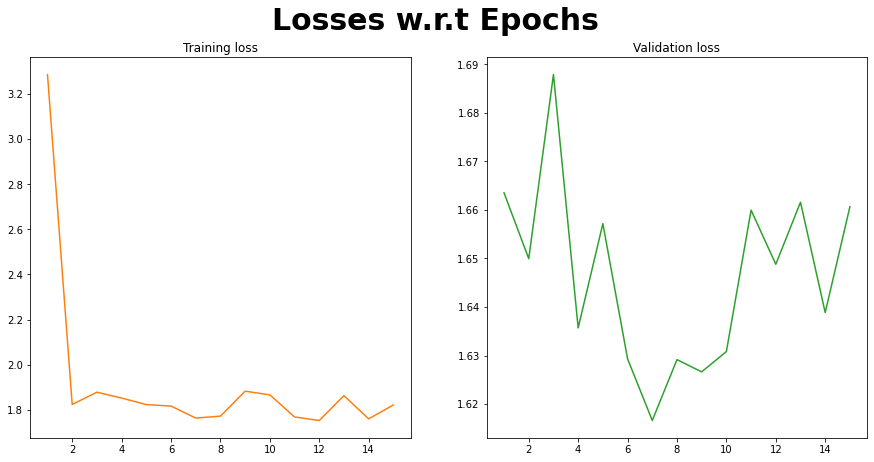

In [17]:
train_model(model, criterion, optimizer, scheduler, num_epochs=15,patience=10, checkpoint=True)

In [18]:
# checkpoint = torch.load('checkpoint.tar')
# # model.load_state_dict(checkpoint['State_dic'])
# optimizer.load_state_dict(checkpoint['Optimizer'])

# **Checking Testing Dataset**

In [19]:
def check_accuracy(loader, model, train=True):
    num_correct = num_samples = 0
    model.eval()
    
    with torch.no_grad():
      for input, labels in loader:
        input = input.to(device=device)
        labels = labels.to(device=device)
        batch_size = input.shape[0]
    
        outputs = model(input)
        _, preds = outputs.max(1)
        num_correct += (preds == labels).sum()
        num_samples += preds.size(0)
    
    accuracy = (num_correct.item()/num_samples)*100
    
    print(f"Model Predicted {num_correct.item()} correctly out of {num_samples} from Testing dataset, Accuracy : {accuracy:.2f}")

    model.train()

# check_accuracy(dataloaders['train'], model)
check_accuracy (dataloaders['test'], model, train=False)
# 'Model Predicted 746 correctly out of 1080 from Testing dataset, Accuracy : 69.07'

Model Predicted 817 correctly out of 1080 from Testing dataset, Accuracy : 75.65


# **Checking Model Prediction with Single Images**

In [20]:
# model = torch.load(PATH)
import io
from PIL import Image
model.eval()

def transform_image(image_bytes):
    my_transforms = transforms.Compose([transforms.Resize(224),
                                        transforms.CenterCrop(200),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image = Image.open(io.BytesIO(image_bytes))
    return my_transforms(image).unsqueeze(0)


def get_prediction(image_bytes):
    tensor = transform_image(image_bytes=image_bytes)
    tensor = tensor.to(device)
    output = model(tensor)

    prob, classes = torch.max(output, 1)
    name=idx_to_cls[classes.item()]
    return name

def read_image(image_path):
#     image_path = input("Past the Path - ")
    # Need to convert Image_path into Image for watching at the end
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    f = open(image_path, 'rb') 
    image_bytes = f.read()
    # need to give original image path, because it is transforming
    name= get_prediction(image_bytes=image_bytes)
    name = name.split('.')[-1]

    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.title(f"This is {name}")

# read_image(image_path)

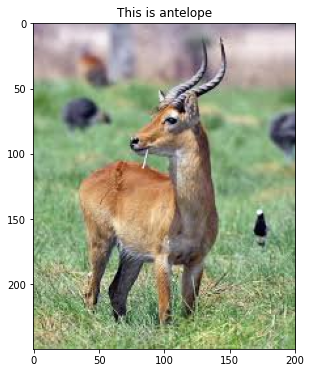

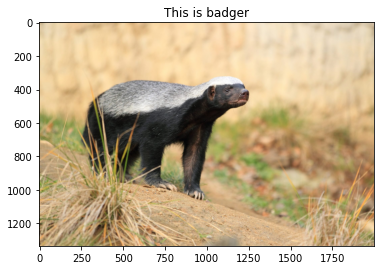

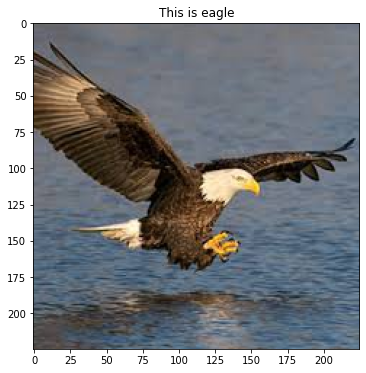

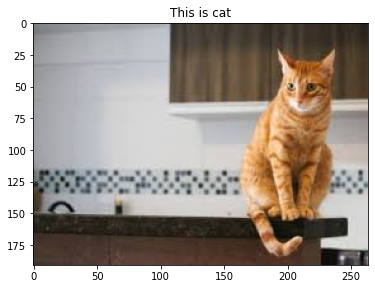

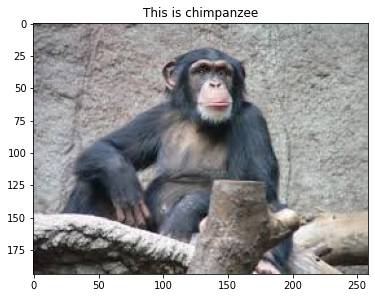

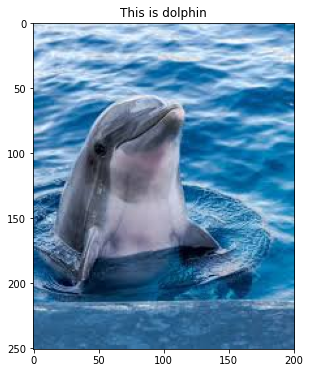

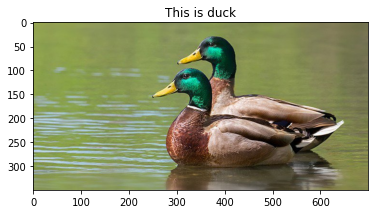

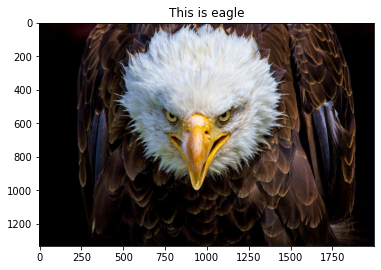

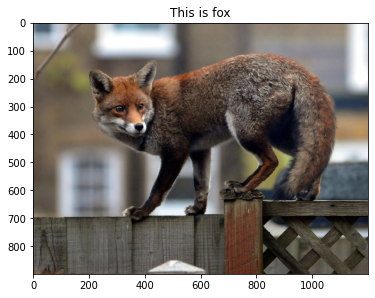

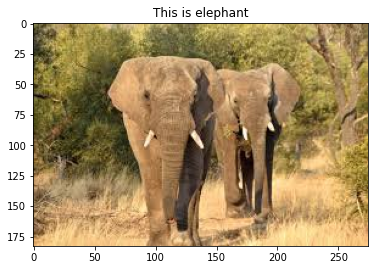

In [21]:
images = [
    '../input/animal-image-dataset-90-different-animals/animals/animals/antelope/0c16ef86c0.jpg',
    '../input/animal-image-dataset-90-different-animals/animals/animals/badger/2c8396c663.jpg',
    '../input/animal-image-dataset-90-different-animals/animals/animals/eagle/29c53bd78f.jpg',
    '../input/animal-image-dataset-90-different-animals/animals/animals/cat/1a2dce7848.jpg',
    '../input/animal-image-dataset-90-different-animals/animals/animals/chimpanzee/08a7290f4d.jpg',
    '../input/animal-image-dataset-90-different-animals/animals/animals/dolphin/28dba6a409.jpg',
    '../input/animal-image-dataset-90-different-animals/animals/animals/duck/205a76a4d6.jpg',
    '../input/animal-image-dataset-90-different-animals/animals/animals/eagle/3c6c8999a5.jpg',
    '../input/animal-image-dataset-90-different-animals/animals/animals/fox/0ae0157e0c.jpg',
    '../input/animal-image-dataset-90-different-animals/animals/animals/elephant/0e81eb0721.jpg'
]
for i in images:
    read_image(i)